In [1]:
import numpy as np

def _read_csv(data_dir, file_name):
    import csv
    with open(data_dir + '/' + file_name + '.csv', 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        return list(reader)

def _read_text(data_dir, file_name):
    with open(data_dir + '/' + file_name + '.txt', 'r') as textfile:
        return textfile.readlines()
    
def load(data_dir):
    alphabet = _read_csv(data_dir, 'alphabet')[0]
    P = np.array(_read_csv(data_dir, 'letter_probabilities')[0], dtype=np.float64)
    M = np.array(_read_csv(data_dir, 'letter_transition_matrix'), dtype=np.float64)
    cipher_function = _read_csv(data_dir, 'cipher_function')[0]
    plaintext = _read_text(data_dir, 'plaintext')[0]
    ciphertext = _read_text(data_dir, 'ciphertext')[0]
    return alphabet, P, M, cipher_function, plaintext, ciphertext

alphabet, P, M, cipher_function, plaintext, ciphertext = load('./data')

logP = np.log(P)
M[M==0] = 1
logM = np.log(M)
#logM[logM==0] = -1e10

print(len(plaintext))

27321


In [2]:
dictionary = dict(zip(alphabet, range(len(alphabet))))

def translate(text):
    return np.array([dictionary[t] for t in text if t != '\n'])

plaincode = translate(plaintext)
ciphercode = translate(ciphertext)
f_true = translate(cipher_function)

In [27]:
def initialize(num, order):
    x = np.zeros((num, order), dtype=np.float64)
    for i in range(num):
        x[i,] = np.random.permutation(order)
    return x

def proposal_change(x):
    def _roll(_x):
        idx = np.random.choice(_x.shape[0], 2, replace=False)
        _x[idx] = _x[np.roll(idx, 1)]
        return _x
    xp = np.apply_along_axis(_roll, 1, np.copy(x))
    return xp

def get_log_probs(x, logP, logM, ciphercode):
    ps = np.zeros((x.shape[0], ciphercode.shape[0]))
    xinv = np.argsort(x, axis=1)
    ps[:,0] = logP[xinv[:,ciphercode[0]]]
    ps[:,1:] = logM[xinv[:,ciphercode[1:]],xinv[:,ciphercode[:-1]]]
    return np.sum(ps, axis=1)

def random_step(logpr):
    pr = np.exp(np.clip(logpr, -np.inf, 0))
    return (np.random.rand(pr.shape[0]) < pr).astype(np.int)

def update(x, xp, rs):
    rs = rs.reshape((rs.shape[0],1))
    return (rs*xp+(1-rs)*x)

def get_acc(x, ciphercode, plaincode):
    xinv = np.argsort(x, axis=1)
    plaincode = np.repeat(plaincode.reshape((1,-1)), x.shape[0], axis=0)
    return np.sum((xinv[:,ciphercode] == plaincode).astype(np.int))/x.shape[0]/ciphercode.shape[0]


def main(num, order, logP, logM, ciphercode, plaincode, maxiter, T):
    x = initialize(num, order)
    rs_mean = 0
    logp_list, accept_rate_list, acc_list = [], [], []
    for i in range(maxiter):
        xp = proposal_change(x)
        logp = get_log_probs(x, logP, logM, ciphercode)
        logp_list.append(np.mean(logp))
        logpp = get_log_probs(xp, logP, logM, ciphercode)
        logpr = logpp - logp
        rs = random_step(logpr)
        accept_rate_list.append(np.mean(rs))
        rs_mean += np.mean(rs)/T
        x = update(x, xp, rs)
        acc = get_acc(x, ciphercode, plaincode)
        acc_list.append(np.mean(acc))
        if i % T == 0:
            print("iter:{}, log_prob:{:1.4e}, accept_rate:{:1.4e}, accuracy:{:1.4e}".format(i, np.mean(logp), rs_mean, acc))
            rs_mean = 0
    return logp_list, accept_rate_list, acc_list


lengths = [len(plaincode)]
logp_lists = []
for length in lengths:
    logp_list, accept_rate_list, acc_list = main(1, 28, logP, logM, ciphercode[:length], plaincode[:length], 5000, 100)
    logp_lists.append(logp_list)
    print('')

iter:0, log_prob:-1.4070e+05, accept_rate:0.0000e+00, accuracy:6.5300e-02
iter:100, log_prob:-1.0027e+05, accept_rate:2.1000e-01, accuracy:7.3206e-05
iter:200, log_prob:-8.6672e+04, accept_rate:1.7000e-01, accuracy:2.7965e-02
iter:300, log_prob:-8.4305e+04, accept_rate:7.0000e-02, accuracy:2.2881e-01
iter:400, log_prob:-7.9698e+04, accept_rate:7.0000e-02, accuracy:2.8298e-01
iter:500, log_prob:-7.3588e+04, accept_rate:7.0000e-02, accuracy:2.3807e-01
iter:600, log_prob:-7.3074e+04, accept_rate:1.0000e-02, accuracy:2.3807e-01
iter:700, log_prob:-7.1154e+04, accept_rate:3.0000e-02, accuracy:2.1878e-01
iter:800, log_prob:-7.1154e+04, accept_rate:0.0000e+00, accuracy:2.1878e-01
iter:900, log_prob:-7.1137e+04, accept_rate:1.0000e-02, accuracy:2.1878e-01
iter:1000, log_prob:-7.0602e+04, accept_rate:3.0000e-02, accuracy:3.1380e-01
iter:1100, log_prob:-7.0146e+04, accept_rate:0.0000e+00, accuracy:3.1380e-01
iter:1200, log_prob:-7.0099e+04, accept_rate:1.0000e-02, accuracy:3.9824e-01
iter:1300, 

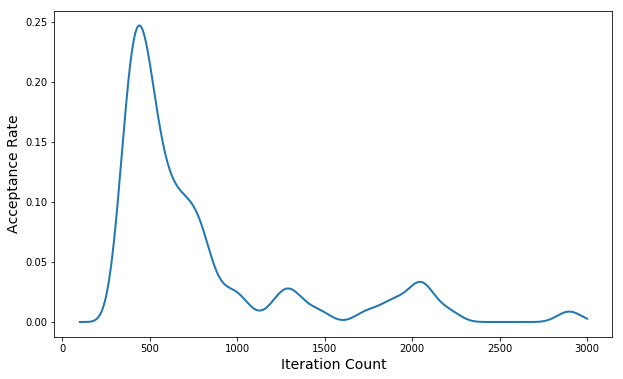

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
ksize = 100
accept_rate_list = np.convolve(accept_rate_list, np.ones(ksize))/100
start = 0
end = 2900
#for logp_list, length in zip(logp_lists, lengths):
#    plt.plot(range(start, len(logp_list[start:end])+start), np.array(logp_list[start:end])/np.log(2)/length, '-', linewidth=2)
plt.plot(range(ksize+start, len(accept_rate_list[start:end])+ksize+start), np.array(accept_rate_list[start:end])/np.log(2), '-', linewidth=2)
plt.xlabel('Iteration Count', fontsize=14)
plt.ylabel('Acceptance Rate', fontsize=14)
#plt.legend(['text length = {}'.format(length) for length in lengths])
plt.show()

In [19]:
np.mean((np.array(logp_lists[0])/np.log(2)/lengths[0])[-1000:])

-3.503601535034464